In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [2]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-97khe6m2
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-97khe6m2
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29643 sha256=a19ba49a267bf175b29a24720cd6c1fb5484fe59eb38c7f8c9706b46113331e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-u71erycv/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [3]:
from ImageDataAugmentor.image_data_augmentor import *

In [4]:
data_dir = Path('drive/MyDrive/dataset-resized')
filepaths = list(data_dir.glob(r'**/*.jpg'))
def proc_img(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(6)

,Filepath,Label
0,drive/MyDrive/dataset-resized/glass/glass160.jpg,glass
1,drive/MyDrive/dataset-resized/paper/paper37.jpg,paper
2,drive/MyDrive/dataset-resized/paper/paper346.jpg,paper
3,drive/MyDrive/dataset-resized/trash/trash53.jpg,trash
4,drive/MyDrive/dataset-resized/paper/paper360.jpg,paper
5,drive/MyDrive/dataset-resized/metal/metal129.jpg,metal


In [5]:
print(f'Number of pics: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Lables: {df.Label.unique()}')

Number of pics: 2527

Number of different labels: 6

Lables: ['glass' 'paper' 'trash' 'metal' 'plastic' 'cardboard']


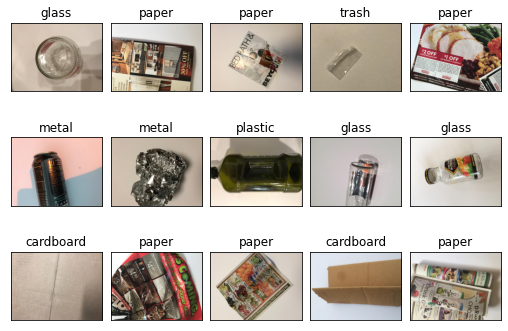

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(7, 5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df.Filepath[i]))
  ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

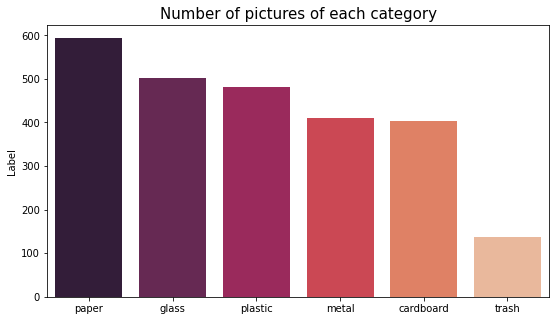

In [7]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sb.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [8]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((2274, 2), (253, 2))

In [9]:
import numpy as np
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory('drive/MyDrive/dataset-resized', target_size = (150, 150), batch_size = 32, class_mode = 'categorical', subset='training')
val_gen = train_datagen.flow_from_directory('drive/MyDrive/dataset-resized', target_size = (150, 150), batch_size = 32, class_mode = 'categorical', subset='validation')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [10]:
# Initialising the CNN(레이어를 선형으로 연결하여 구성)
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution ('Relu'는 다른 activation function에 비해 속도가 빠름)
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling(convolution filter를 거친 결과로 얻은 feature map에서 특정영역을 형성 후 해당 영역에서 가장 큰 값 도출)
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening (Data Type을 fully connected 네트워크 형태로 변경)
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection (Convolution과 Pooling 프로세스를 기반으로 labelling)
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer (6개의 class로 분류)
cnn.add(tf.keras.layers.Dense(units=6, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [11]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
64/64 [==============================] - 357s 6s/step - loss: 1.8129 - accuracy: 0.3266 - val_loss: 1.6222 - val_accuracy: 0.3658
Epoch 2/10
64/64 [==============================] - 40s 620ms/step - loss: 1.2970 - accuracy: 0.4931 - val_loss: 1.4106 - val_accuracy: 0.4592
Epoch 3/10
64/64 [==============================] - 39s 613ms/step - loss: 1.0176 - accuracy: 0.6260 - val_loss: 1.4024 - val_accuracy: 0.4771
Epoch 4/10
64/64 [==============================] - 40s 630ms/step - loss: 0.7678 - accuracy: 0.7243 - val_loss: 1.4706 - val_accuracy: 0.4990
Epoch 5/10
64/64 [==============================] - 43s 664ms/step - loss: 0.6189 - accuracy: 0.7900 - val_loss: 1.7425 - val_accuracy: 0.5010
Epoch 6/10
64/64 [==============================] - 41s 631ms/step - loss: 0.4127 - accuracy: 0.8617 - val_loss: 1.7265 - val_accuracy: 0.4871
Epoch 7/10
64/64 [==============================] - 40s 627ms/step - loss: 0.3112 - accuracy: 0.9017 - val_loss: 1.8208 - val_accuracy: 0.5050
E

In [12]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, 
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # Augmentation을 진행할 시, 이미지가 비는 곳에 가까운 곳의 픽셀값으로 채움.
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [16]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# pre_trained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 training 중 손실을 최소화
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 2047 validated image filenames belonging to 6 classes.
Found 227 validated image filenames belonging to 6 classes.
Found 253 validated image filenames belonging to 6 classes.


DenseNet121          trained in 251.11 sec
MobileNetV2          trained in 58.96 sec
74836368/74836368 [==============================] - 0s 0us/step
DenseNet201          trained in 413.42 sec
16705208/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 118.82 sec
27018416/27018416 [==============================] - 0s 0us/step
EfficientNetB1       trained in 187.18 sec
87910968/87910968 [==============================] - 1s 0us/step
InceptionV3          trained in 187.68 sec
12683000/12683000 [==============================] - 0s 0us/step
MobileNetV3Large     trained in 85.84 sec
234545216/234545216 [==============================] - 2s 0us/step
ResNet152V2          trained in 690.55 sec
94765736/94765736 [==============================] - 1s 0us/step
ResNet50          

In [17]:
for name, model in models.items():
    
    # 테스트데이터의 label 예측
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # label 맵핑
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# 나온 결과를 기반으로 DataFrame 생성
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

8/8 [==============================] - 31s 4s/step
**DenseNet121 has a 77.87% accuracy on the test set**
8/8 [==============================] - 8s 865ms/step
**MobileNetV2 has a 80.63% accuracy on the test set**
8/8 [==============================] - 50s 6s/step
**DenseNet201 has a 82.21% accuracy on the test set**
8/8 [==============================] - 14s 2s/step
**EfficientNetB0 has a 18.97% accuracy on the test set**
8/8 [==============================] - 18s 2s/step
**EfficientNetB1 has a 20.95% accuracy on the test set**
8/8 [==============================] - 21s 2s/step
**InceptionV3 has a 77.87% accuracy on the test set**
8/8 [==============================] - 7s 783ms/step
**MobileNetV3Large has a 29.64% accuracy on the test set**
8/8 [==============================] - 81s 10s/step
**ResNet152V2 has a 82.21% accuracy on the test set**
8/8 [==============================] - 31s 4s/step
**ResNet50 has a 32.81% accuracy on the test set**
8/8 [==============================] - 27s

,model,val_accuracy,accuracy,Training time (sec)
0,Xception,0.8018,0.8577,478.71
1,ResNet50V2,0.7974,0.8300,245.65
2,DenseNet201,0.8150,0.8221,413.42
3,ResNet152V2,0.7974,0.8221,690.55
4,MobileNetV2,0.8062,0.8063,58.96
5,DenseNet121,0.7709,0.7787,251.11
6,InceptionV3,0.7974,0.7787,187.68
7,VGG19,0.5903,0.5336,1059.11
8,VGG16,0.5022,0.4901,839.65
9,ResNet50,0.3789,0.3281,284.27


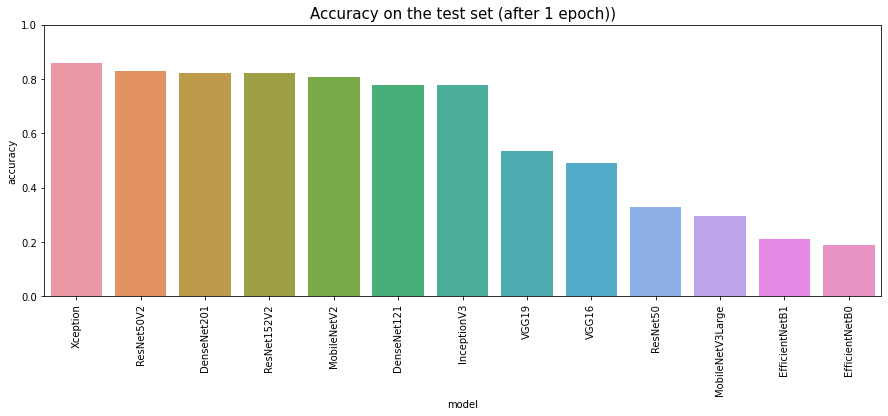

In [19]:
plt.figure(figsize = (15,5))
sb.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [20]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()
#MobileNetV2 성능확인(MobileNetV2가 시간이 적게 들고 동시에 accuracy가 80%정도 기록) 
model = get_model(tf.keras.applications.MobileNetV2)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 2047 validated image filenames belonging to 6 classes.
Found 227 validated image filenames belonging to 6 classes.
Found 253 validated image filenames belonging to 6 classes.
Epoch 1/7
64/64 [==============================] - 65s 971ms/step - loss: 0.7725 - accuracy: 0.7093 - val_loss: 0.5249 - val_accuracy: 0.7841
Epoch 2/7
64/64 [==============================] - 64s 1s/step - loss: 0.4018 - accuracy: 0.8530 - val_loss: 0.5419 - val_accuracy: 0.8018
Epoch 3/7
64/64 [==============================] - 61s 953ms/step - loss: 0.2298 - accuracy: 0.9238 - val_loss: 0.4413 - val_accuracy: 0.8062
Epoch 4/7
64/64 [==============================] - 60s 920ms/step - loss: 0.1292 - accuracy: 0.9648 - val_loss: 0.4713 - val_accuracy: 0.8150
Epoch 5/7
64/64 [==============================] - 60s 936ms/step - loss: 0.0724 - accuracy: 0.9809 - val_loss: 0.4925 - val_accuracy: 0.8194
Epoch 6/7
64/64 [==============================] - 56s 873ms/step - loss: 0.0430 - accuracy: 0.9902 - val_loss: 

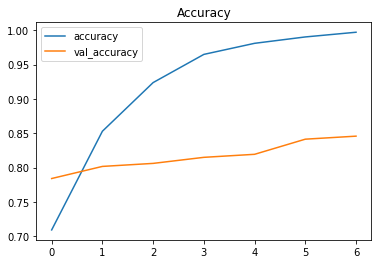

In [21]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

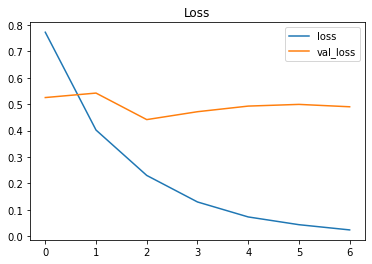

In [22]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [23]:
# test 이미지 예측
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# label 맵핑
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

8/8 [==============================] - 7s 729ms/step
Accuracy on the test set: 85.77%


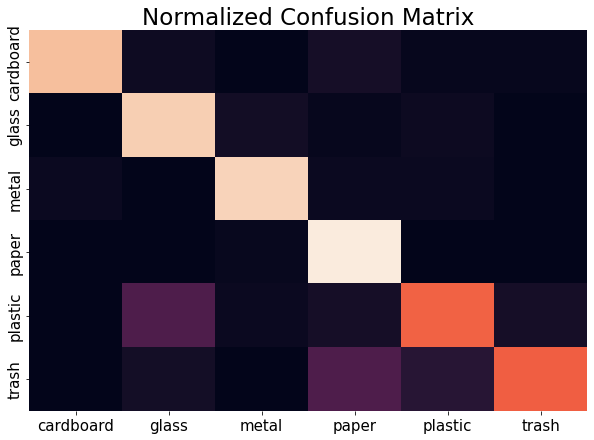

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

번호를 입력하세요 : 75
1/1 [==============================] - 0s 63ms/step


## 예측률 : 99.99%

### Class prediction = cardboard

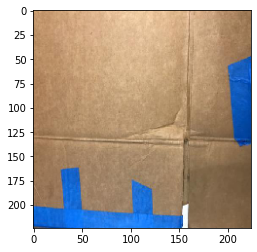

In [29]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'cardboard': 0,
                    'glass': 1,
                    'metal': 2,
                    'paper': 3,
                    'plastic': 4,
                    'trash': 5
                    }
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

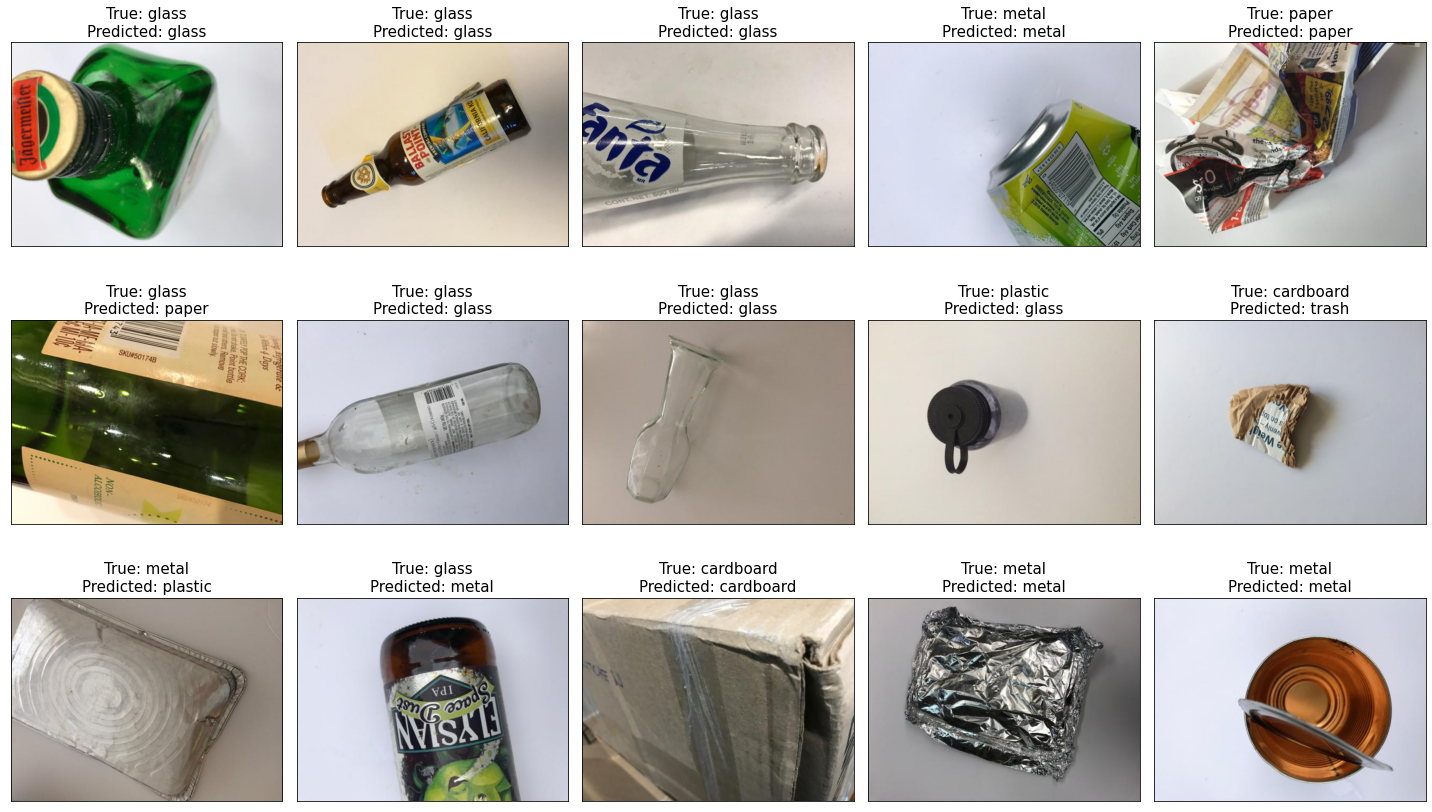

In [33]:
# 여러 이미지를 예측(실제 값과 예측 값 labeling)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [32]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)